In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab4.ipynb")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from src.utils import custom_train_test_split, compute_feature_engineering, get_important_features_important_than
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import shap
import os


DATA_PATH = "data/AB_NYC_2019.csv"
TARGET = "reviews_per_month"
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Lab 4: Putting it all together in a mini project

For this lab, **you can choose to work alone or in a group of up to three students**. You are in charge of how you want to work and who you want to work with. Maybe you really want to go through all the steps of the ML process yourself or maybe you want to practice your collaboration skills, it is up to you! Just remember to indicate who your group members are (if any) when you submit on Gradescope. If you choose to work in a group, you only need to use one GitHub repo (you can create one on github.ubc.ca and set the visibility to "public"). If it takes a prohibitively long time to run any of the steps on your laptop, it is OK if you sample the data to reduce the runtime, just make sure you write a note about this.

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## Submission instructions
rubric={mechanics}

<p>You receive marks for submitting your lab correctly, please follow these instructions:</p>

<ul>
  <li><a href="https://ubc-mds.github.io/resources_pages/general_lab_instructions/">
      Follow the general lab instructions.</a></li>
  <li><a href="https://github.com/UBC-MDS/public/tree/master/rubric">
      Click here to view a description of the rubrics used to grade the questions</a></li>
  <li>Make at least three commits.</li>
  <li>Push your <code>.ipynb</code> file to your GitHub repository for this lab and upload it to Gradescope.</li>
    <ul>
      <li>Before submitting, make sure you restart the kernel and rerun all cells.</li>
    </ul>
  <li>Make sure to only make one gradescope submission per group, and to assign all group members on gradescope at submission time.</li>
  <li>Also upload a <code>.pdf</code> export of the notebook to facilitate grading of manual questions (preferably WebPDF, you can select two files when uploading to gradescope)</li>
  <li>Don't change any variable names that are given to you, don't move cells around, and don't include any code to install packages in the notebook.</li>
  <li>The data you download for this lab <b>SHOULD NOT BE PUSHED TO YOUR REPOSITORY</b> (there is also a <code>.gitignore</code> in the repo to prevent this).</li>
  <li>Include a clickable link to your GitHub repo for the lab just below this cell
    <ul>
      <li>It should look something like this https://github.ubc.ca/MDS-2020-21/DSCI_531_labX_yourcwl.</li>
    </ul>
  </li>
</ul>
</div>


_Points:_ 2

[FIND HERE OUR REPOSITORY 👻](https://github.com/hpalafoxp/DSCI-573-Lab4)

##### Collaborators:

- Elí González Zequeida (`@Eligozo75`): Section 1
- Héctor Palafox Prieto (`@hpalafoxp`): Section 1
- Luis Alonso Álvarez Portugal (`@luisalonso8`): Section 2

<!-- END QUESTION -->

## Introduction <a name="in"></a>

In this lab you will be working on an open-ended mini-project, where you will put all the different things you have learned so far in 571 and 573 together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips
1. Since this mini-project is open-ended there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 

#### Assessment
We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you instead try several reasonable approaches and you have clearly motivated your choices, but still get lower model performance than your friend, don't sweat it.


#### A final note
Finally, the style of this "project" is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "several hours" but not "many hours" is a good guideline for a high quality submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and we hope you enjoy it as well. 

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 1. Pick your problem and explain the prediction problem <a name="1"></a>
rubric={reasoning}

In this mini project, you will pick one of the following problems: 

1. A classification problem of predicting whether a credit card client will default or not. For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 

OR 

2. A regression problem of predicting `reviews_per_month`, as a proxy for the popularity of the listing with [New York City Airbnb listings from 2019 dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data). Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 
3. Carry out any preliminary preprocessing, if needed (e.g., changing feature names, handling of NaN values etc.)
    
</div>


_Points:_ 3

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 2. Data splitting <a name="2"></a>
rubric={reasoning}

**Your tasks:**

1. Split the data into train and test portions.

> Make the decision on the `test_size` based on the capacity of your laptop. 
    
</div>


_Points:_ 1

In [3]:
path = 'data/split_data/train_set.csv'

# Check if the path is a file
if os.path.isfile(path):
    print(f"The file exists.")
else:
    print("Didn't find the datasets. Creating them from scratch:")
    %run src/jobs/01_split_data.py

The file exists.


In [4]:
df = pd.read_csv(DATA_PATH)
df = df.dropna(subset=[TARGET])
print(df.shape)
df.head()

(38843, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [5]:
df_train, df_test = custom_train_test_split(df, "host_id")


print("PCT of rows in train:", 100.0 * len(df_train) / len(df))
print("PCT of rows in test:", 100.0 * len(df_test) / len(df))

PCT of rows in train: 69.99974255335582
PCT of rows in test: 30.000257446644184


In [6]:
not_use_cols = [
    'id',
    'host_id',
    'host_name',
    'last_review',
]
use_cols = [c for c in df if c not in not_use_cols]
df_train = df_train[use_cols].copy()
df_test = df_test[use_cols].copy()

In [7]:
df_train.to_csv("data/split_data/train_set.csv",index=False)
df_test.to_csv("data/split_data/test_set.csv",index=False)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 3. EDA <a name="3"></a>
rubric={viz,reasoning}
    
Perform exploratory data analysis on the train set.

**Your tasks:**

1. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
2. Summarize your initial observations about the data. 
3. Pick appropriate metric/metrics for assessment. 
    
</div>


_Points:_ 6

_Type your answer here, replacing this text._

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27190 entries, 0 to 27189
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            27184 non-null  object 
 1   neighbourhood_group             27190 non-null  object 
 2   neighbourhood                   27190 non-null  object 
 3   latitude                        27190 non-null  float64
 4   longitude                       27190 non-null  float64
 5   room_type                       27190 non-null  object 
 6   price                           27190 non-null  int64  
 7   minimum_nights                  27190 non-null  int64  
 8   number_of_reviews               27190 non-null  int64  
 9   reviews_per_month               27190 non-null  float64
 10  calculated_host_listings_count  27190 non-null  int64  
 11  availability_365                27190 non-null  int64  
dtypes: float64(3), int64(5), object(

In [9]:
df_train.isna().mean()

name                              0.000221
neighbourhood_group               0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
reviews_per_month                 0.000000
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

In [10]:
df_train.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000,27190.000000
mean,40.727681,-73.950990,142.489702,5.790953,29.232953,1.368443,3.478301,115.066238
std,0.055250,0.046678,206.368954,16.108038,48.545982,1.706042,12.036135,129.711941
min,40.508680,-74.244420,0.000000,1.000000,1.000000,0.010000,1.000000,0.000000
25%,40.688240,-73.982270,68.000000,1.000000,3.000000,0.190000,1.000000,0.000000
50%,40.721180,-73.954550,100.000000,2.000000,9.000000,0.700000,1.000000,55.000000
75%,40.762910,-73.935342,169.000000,4.000000,33.000000,2.000000,2.000000,230.000000
max,40.908040,-73.712990,10000.000000,999.000000,629.000000,58.500000,232.000000,365.000000


In [11]:
df_train.groupby("neighbourhood_group")[TARGET].mean().sort_values(ascending=False)

neighbourhood_group
Queens           1.958524
Staten Island    1.854872
Bronx            1.761455
Brooklyn         1.283295
Manhattan        1.260512
Name: reviews_per_month, dtype: float64

In [12]:
df_train["neighbourhood"].value_counts(True)

neighbourhood
Williamsburg          0.083854
Bedford-Stuyvesant    0.083339
Harlem                0.056933
Bushwick              0.048547
Upper West Side       0.038911
                        ...   
West Farms            0.000037
Westerleigh           0.000037
Shore Acres           0.000037
Lighthouse Hill       0.000037
Silver Lake           0.000037
Name: proportion, Length: 216, dtype: float64

In [13]:
df_train.groupby("neighbourhood", as_index=False).agg(
    {TARGET: ["mean", "count"]}
).sort_values(by=("reviews_per_month", "mean"), ascending=False)

neighbourhood reviews_per_month      
                                      mean count
139       New Dorp Beach          5.500000     2
173          Silver Lake          5.490000     1
58         East Elmhurst          5.150650   123
208           Whitestone          5.060000     2
179  Springfield Gardens          4.743731    67
..                   ...               ...   ...
96            Holliswood          0.310000     1
145              Oakwood          0.285000     2
172          Shore Acres          0.280000     1
204           West Farms          0.160000     1
119          Marble Hill          0.138571     7

[216 rows x 3 columns]

In [14]:
df_train["room_type"].value_counts(True)

room_type
Entire home/apt    0.519934
Private room       0.457595
Shared room        0.022471
Name: proportion, dtype: float64

In [15]:
df_train.groupby("room_type")[TARGET].mean().sort_values(ascending=False)

room_type
Private room       1.445947
Shared room        1.433863
Entire home/apt    1.297404
Name: reviews_per_month, dtype: float64

In [16]:
df_train["neighbourhood_group"].value_counts(True).sort_values(ascending=True)

neighbourhood_group
Staten Island    0.008606
Bronx            0.021478
Queens           0.117837
Manhattan        0.421736
Brooklyn         0.430342
Name: proportion, dtype: float64

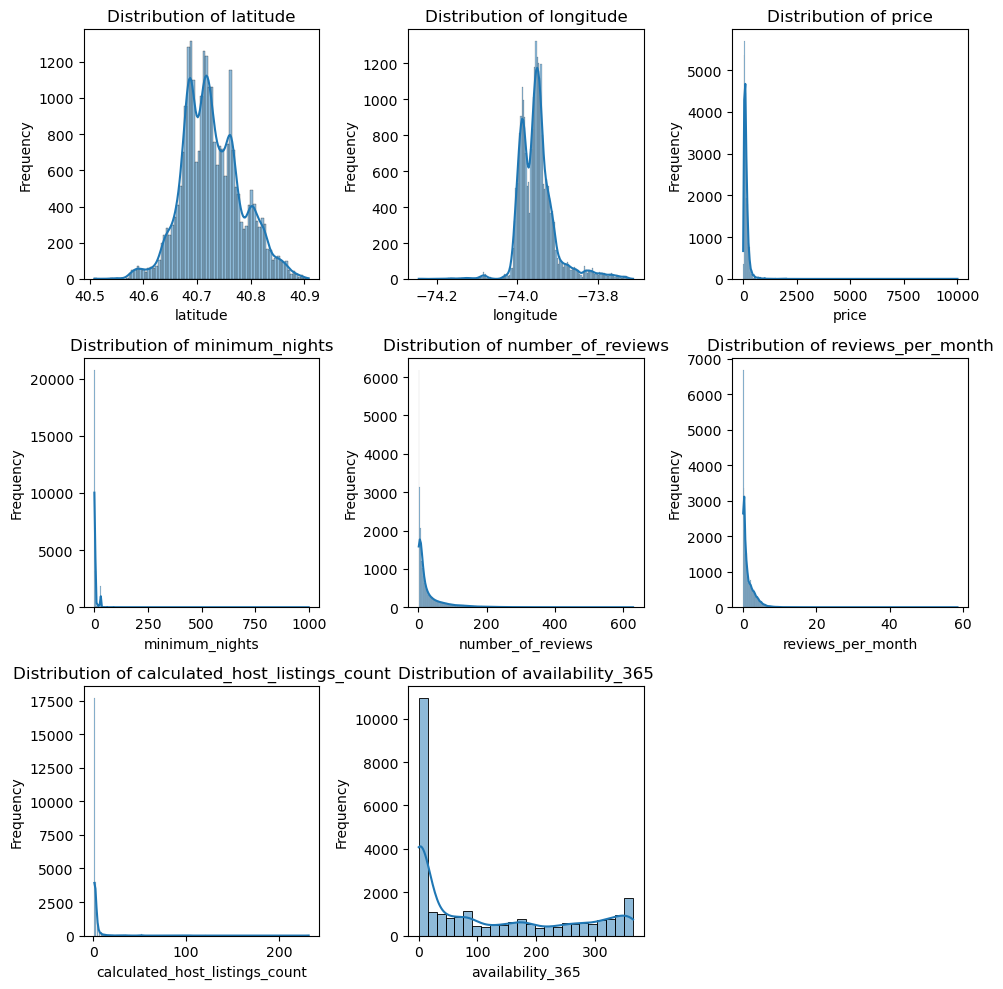

In [17]:
cont_cols = [c for c in df_train.describe()]

num_cols_per_row = 3
num_rows = int(np.ceil(len(cont_cols) / num_cols_per_row))

# Create the figure and subplots
fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(10, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Plot histograms for each column
for i, col in enumerate(cont_cols):
    sns.histplot(df_train[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Remove any unused subplots if the number of columns is not a multiple of 3
for j in range(len(cont_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

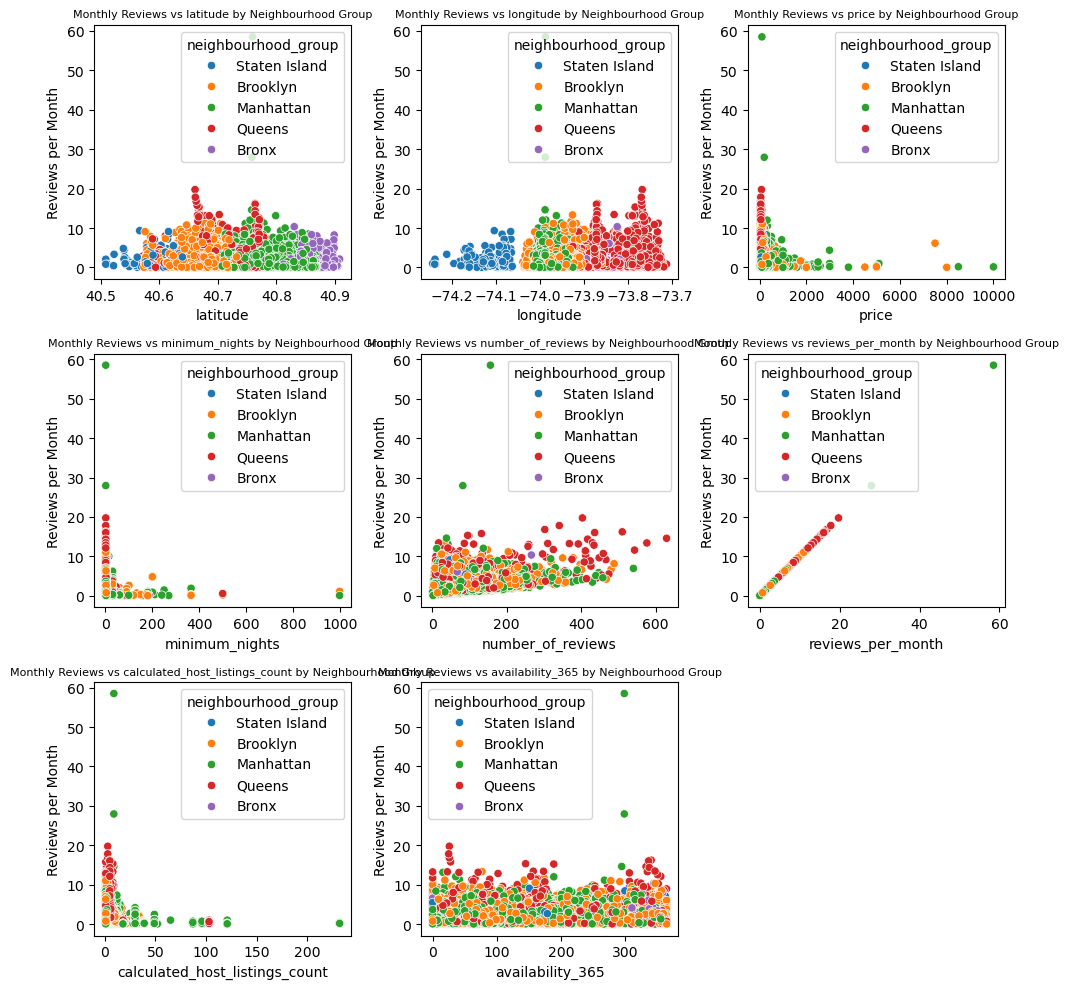

In [18]:
num_cols_per_row = 3
num_rows = int(np.ceil(len(cont_cols) / num_cols_per_row))

# Create the figure and subplots
fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(10, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Plot histograms for each column
for i, col in enumerate(cont_cols):
    sns.scatterplot(
        x=df_train[col],
        y=df_train[TARGET],
        hue=df_train["neighbourhood_group"],
        ax=axes[i],
    )
    axes[i].set_title(f"Monthly Reviews vs {col} by Neighbourhood Group", fontsize=8)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Reviews per Month")

# Remove any unused subplots if the number of columns is not a multiple of 3
for j in range(len(cont_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

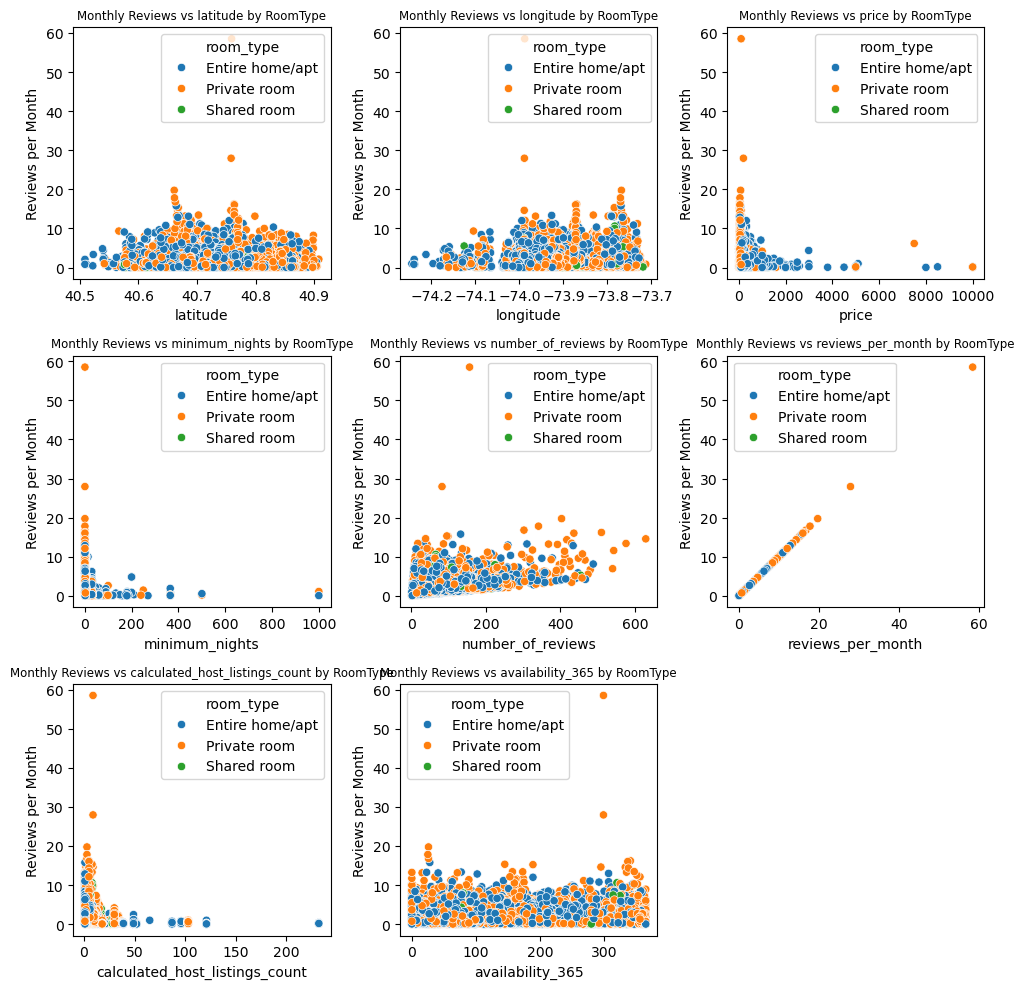

In [19]:
num_cols_per_row = 3
num_rows = int(np.ceil(len(cont_cols) / num_cols_per_row))

# Create the figure and subplots
fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(10, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Plot histograms for each column
for i, col in enumerate(cont_cols):
    sns.scatterplot(
        x=df_train[col],
        y=df_train[TARGET],
        hue=df_train["room_type"],
        ax=axes[i],
    )
    axes[i].set_title(f"Monthly Reviews vs {col} by RoomType",fontsize=8.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Reviews per Month")

# Remove any unused subplots if the number of columns is not a multiple of 3
for j in range(len(cont_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

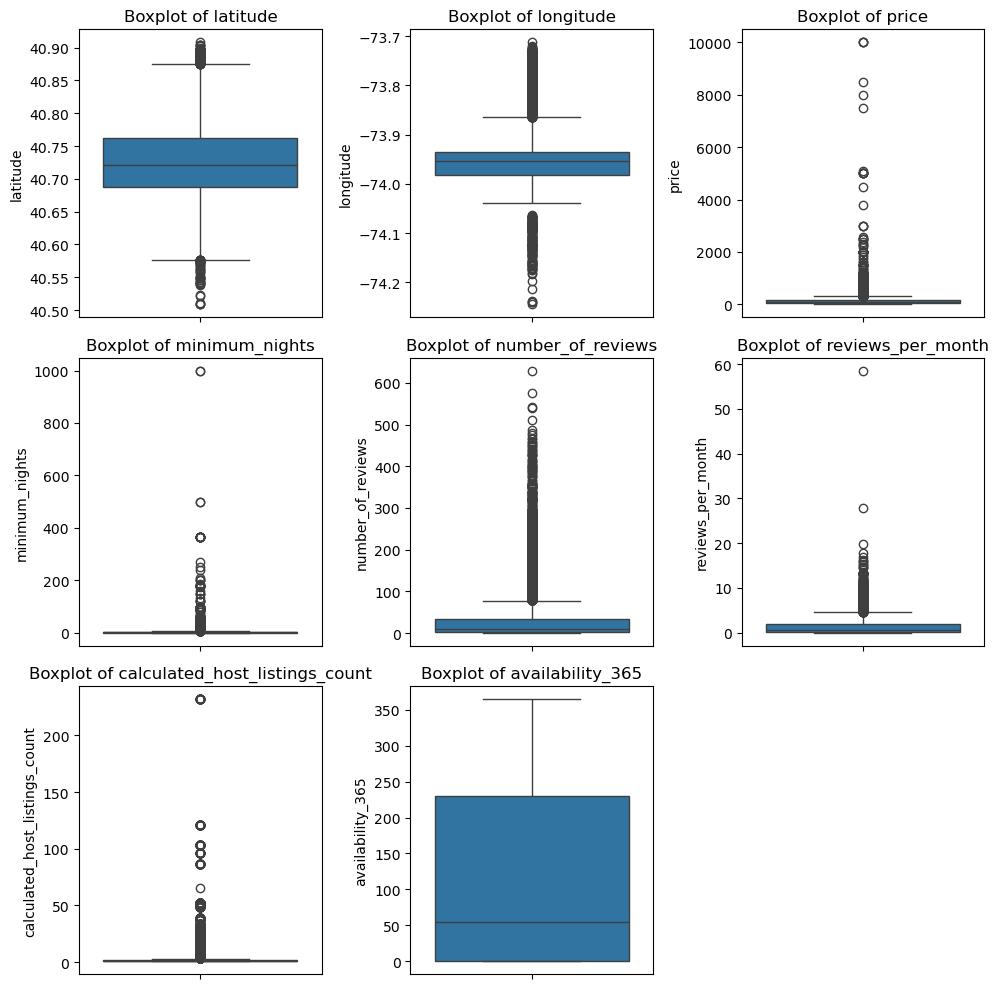

In [20]:
num_cols_per_row = 3
num_rows = int(np.ceil(len(cont_cols) / num_cols_per_row))

# Create the figure and subplots
fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(10, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Plot histograms for each column
for i, col in enumerate(cont_cols):
    sns.boxplot(df_train[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

# Remove any unused subplots if the number of columns is not a multiple of 3
for j in range(len(cont_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

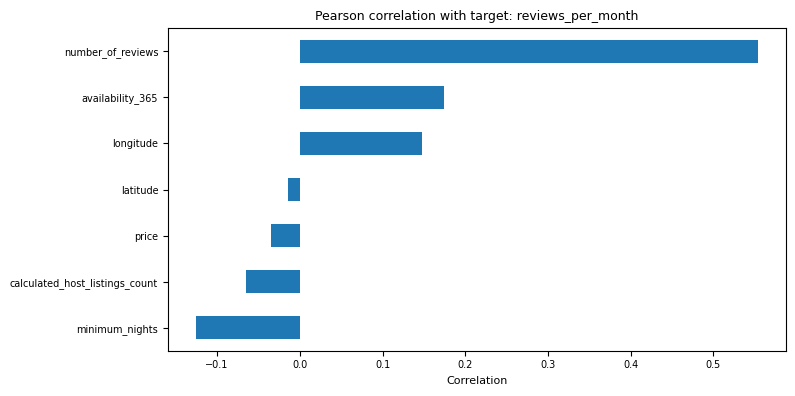

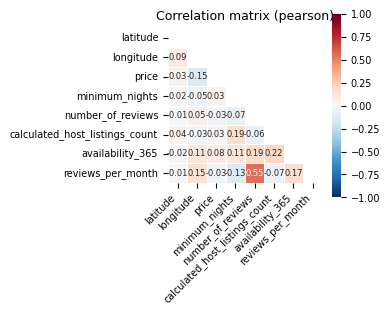

In [21]:
plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 9,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
})

num_cols = df_train.select_dtypes(include="number").columns.tolist()
cont_cols = [c for c in num_cols if c != TARGET]

method = "pearson"

corr_df = df_train[cont_cols + [TARGET]].corr(method=method)

feat_corr = corr_df[TARGET].drop(TARGET).sort_values()

plt.figure(figsize=(8, max(4, 0.28 * len(feat_corr))))
feat_corr.plot(kind="barh")
plt.title(f"{method.title()} correlation with target: {TARGET}", fontsize=9)
plt.xlabel("Correlation", fontsize=8)
plt.yticks(fontsize=7)
plt.xticks(fontsize=7)
plt.tight_layout()
plt.show()

mask = np.triu(np.ones_like(corr_df, dtype=bool))

plt.figure(figsize=(1 + 0.35 * len(corr_df.columns), 1 + 0.35 * len(corr_df.columns)))
sns.heatmap(
    corr_df,
    mask=mask,
    center=0,
    vmin=-1, vmax=1,              
    cmap="RdBu_r",                
    square=True,
    linewidths=0.5,
    annot=True,
    fmt=".2f",                   
    annot_kws={"size": 6},
    cbar_kws={"shrink": 0.7}
)
plt.title(f"Correlation matrix ({method})", fontsize=9)
plt.xticks(fontsize=7, rotation=45, ha="right")
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-warning">

## 4. Feature engineering (Challenging)
rubric={reasoning}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing.
    
</div>


_Points:_ 0.5

In [22]:
df_train = pd.read_csv("data/split_data/train_set.csv")
df_test = pd.read_csv("data/split_data/test_set.csv")

In [23]:
df_train = compute_feature_engineering(df_train)
print("\n\nFinished TRAIN feature engineering...\n")
df_test = compute_feature_engineering(df_test)
print("\n\nFinished TEST feature engineering...")

COMPUTING FEATURE: nyc_tm_distance_km
COMPUTING FEATURE: nyc_cp_distance_km
COMPUTING FEATURE: nyc_fd_distance_km
COMPUTING FEATURE: jfk_airport_distance_km
COMPUTING FEATURE: lga_airport_distance_km
COMPUTING FEATURE: ewr_airport_distance_km
COMPUTING FEATURE: avg_airport_distance_km
COMPUTING FEATURE: avg_airport_distance_km
COMPUTING FEATURE: avg_airport_distance_km
COMPUTING FEATURE: avg_airport_distance_km
COMPUTING FEATURE: avg_airport_distance_km
COMPUTING FEATURE: avg_airport_distance_km
COMPUTING FEATURE: avg_airport_distance_km
COMPUTING FEATURE: avg_airport_distance_km
COMPUTING FEATURE: avg_airport_distance_km
COMPUTING FEATURE: avg_airport_distance_km
COMPUTING FEATURE: avg_airport_distance_km


Finished TRAIN feature engineering...

COMPUTING FEATURE: nyc_tm_distance_km
COMPUTING FEATURE: nyc_cp_distance_km
COMPUTING FEATURE: nyc_fd_distance_km
COMPUTING FEATURE: jfk_airport_distance_km
COMPUTING FEATURE: lga_airport_distance_km
COMPUTING FEATURE: ewr_airport_distance_km


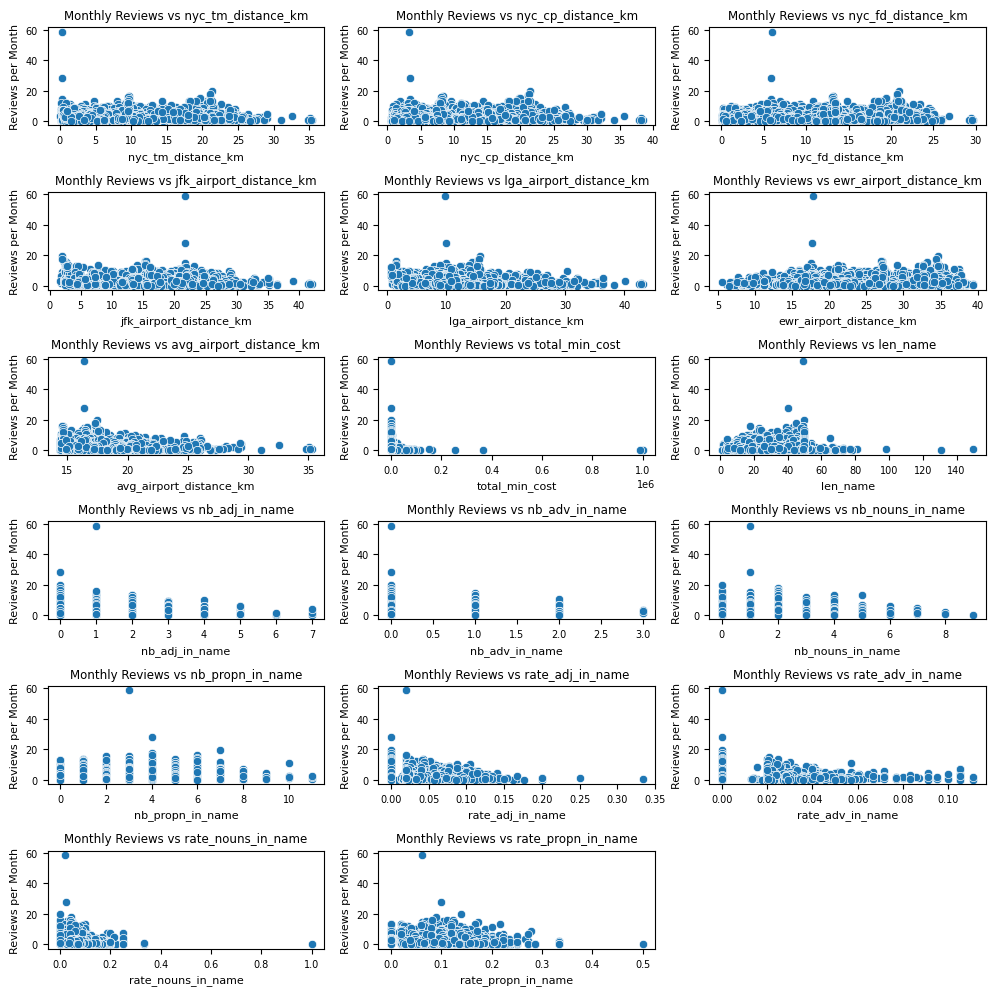

In [24]:
new_features = [
    "nyc_tm_distance_km",
    "nyc_cp_distance_km",
    "nyc_fd_distance_km",
    "jfk_airport_distance_km",
    "lga_airport_distance_km",
    "ewr_airport_distance_km",
    "avg_airport_distance_km",
    "total_min_cost",
    "len_name",
    "nb_adj_in_name",
    "nb_adv_in_name",
    "nb_nouns_in_name",
    "nb_propn_in_name",
    "rate_adj_in_name",
    "rate_adv_in_name",
    "rate_nouns_in_name",
    "rate_propn_in_name",
]

num_cols_per_row = 3
num_rows = int(np.ceil(len(new_features) / num_cols_per_row))

# Create the figure and subplots
fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(10, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Plot histograms for each column
for i, col in enumerate(new_features):
    sns.scatterplot(
        x=df_train[col],
        y=df_train[TARGET],
        ax=axes[i],
    )
    axes[i].set_title(f"Monthly Reviews vs {col}",fontsize=8.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Reviews per Month")

# Remove any unused subplots if the number of columns is not a multiple of 3
for j in range(len(new_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

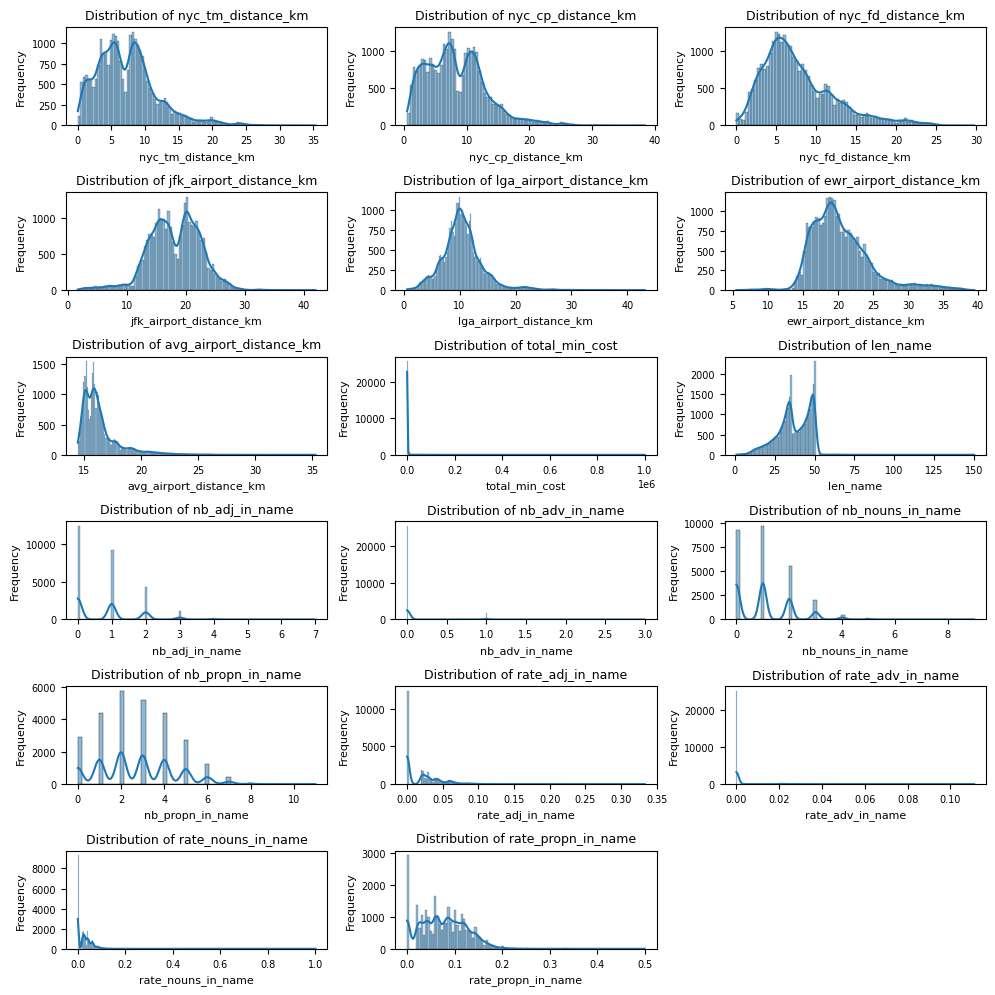

In [25]:
num_cols_per_row = 3
num_rows = int(np.ceil(len(new_features) / num_cols_per_row))

# Create the figure and subplots
fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(10, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Plot histograms for each column
for i, col in enumerate(new_features):
    sns.histplot(df_train[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Remove any unused subplots if the number of columns is not a multiple of 3
for j in range(len(new_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

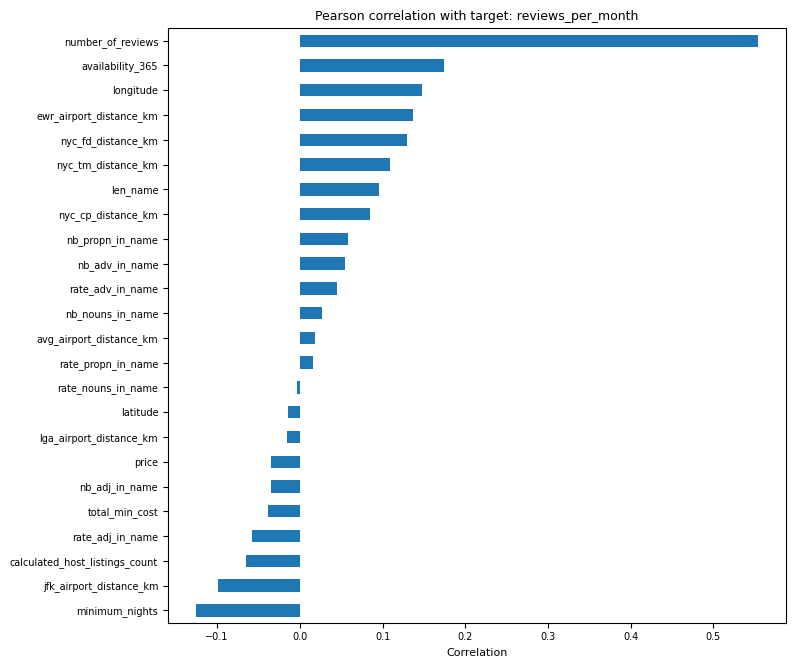

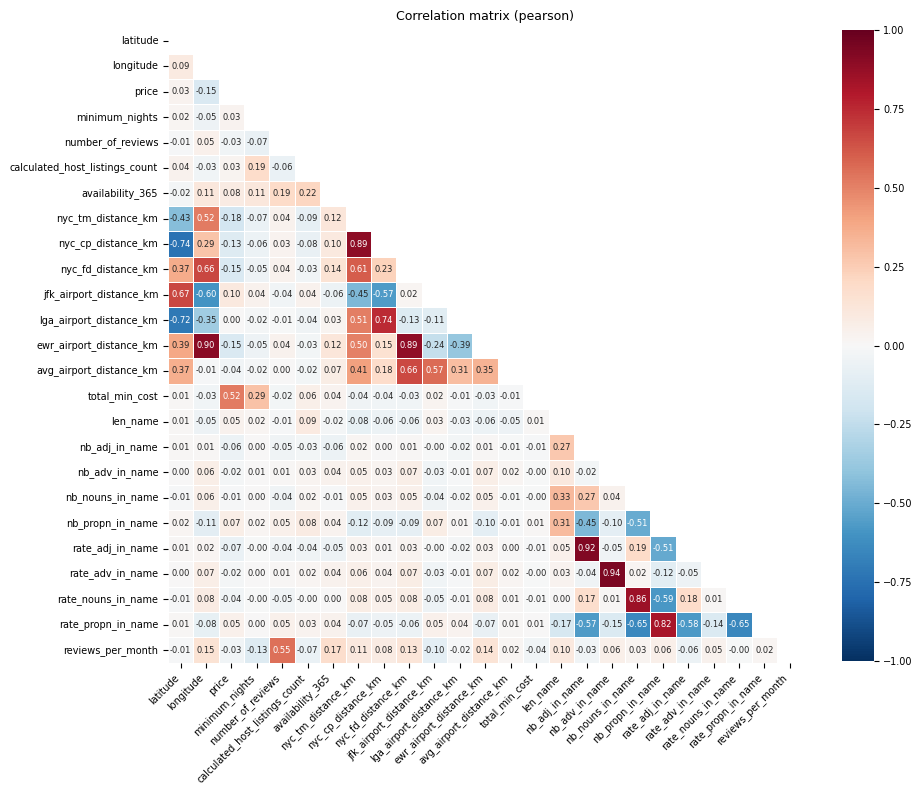

In [26]:
plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 9,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
})

num_cols = df_train.select_dtypes(include="number").columns.tolist()
cont_cols = [c for c in num_cols if c != TARGET]

method = "pearson"

corr_df = df_train[cont_cols + [TARGET]].corr(method=method)

feat_corr = corr_df[TARGET].drop(TARGET).sort_values()

plt.figure(figsize=(8, max(4, 0.28 * len(feat_corr))))
feat_corr.plot(kind="barh")
plt.title(f"{method.title()} correlation with target: {TARGET}", fontsize=9)
plt.xlabel("Correlation", fontsize=8)
plt.yticks(fontsize=7)
plt.xticks(fontsize=7)
plt.tight_layout()
plt.show()

mask = np.triu(np.ones_like(corr_df, dtype=bool))

plt.figure(figsize=(1 + 0.35 * len(corr_df.columns), 1 + 0.35 * len(corr_df.columns)))
sns.heatmap(
    corr_df,
    mask=mask,
    center=0,
    vmin=-1, vmax=1,              
    cmap="RdBu_r",                
    square=True,
    linewidths=0.5,
    annot=True,
    fmt=".2f",                   
    annot_kws={"size": 6},
    cbar_kws={"shrink": 0.7}
)
plt.title(f"Correlation matrix ({method})", fontsize=9)
plt.xticks(fontsize=7, rotation=45, ha="right")
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 5. Preprocessing and transformations <a name="5"></a>
rubric={accuracy,reasoning}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 
    
</div>


_Points:_ 4

In [27]:
cols_w_outliers = [
    "price",
    "minimum_nights",
    "reviews_per_month",
    "calculated_host_listings_count",
]
df_train[cols_w_outliers].describe(percentiles=[0.5,0.75,0.85,0.90,0.95,0.97,0.99,0.995])

,price,minimum_nights,reviews_per_month,calculated_host_listings_count
count,27190.000000,27190.000000,27190.000000,27190.000000
mean,142.489702,5.790953,1.368443,3.478301
std,206.368954,16.108038,1.706042,12.036135
min,0.000000,1.000000,0.010000,1.000000
50%,100.000000,2.000000,0.700000,1.000000
75%,169.000000,4.000000,2.000000,2.000000
85%,200.000000,7.000000,3.000000,3.000000
90%,250.000000,14.000000,3.630000,5.000000
95%,330.000000,30.000000,4.675500,9.000000
97%,400.000000,30.000000,5.420000,17.000000


In [28]:
price_outlier_cond = df_train["price"] < np.percentile(df_train["price"], 99)
minimum_nights_outlier_cond = df_train["minimum_nights"] <= np.percentile(
    df_train["minimum_nights"], 99
)
reviews_per_month_outlier_cond = df_train["reviews_per_month"] <= np.percentile(
    df_train["reviews_per_month"], 99.5
)
listing_count_outlier_cond = df_train["calculated_host_listings_count"] < np.percentile(
    df_train["calculated_host_listings_count"], 99
)

In [29]:
df_train = df_train.loc[
    price_outlier_cond &
    minimum_nights_outlier_cond &
    reviews_per_month_outlier_cond &
    listing_count_outlier_cond
].copy()

In [30]:
df_train[cols_w_outliers].describe(percentiles=[0.5,0.75,0.85,0.90,0.95,0.97,0.99,0.995])

,price,minimum_nights,reviews_per_month,calculated_host_listings_count
count,26311.000000,26311.000000,26311.000000,26311.000000
mean,130.162442,4.781992,1.342145,2.424575
std,91.830858,7.152393,1.535088,4.568263
min,0.000000,1.000000,0.010000,1.000000
50%,100.000000,2.000000,0.720000,1.000000
75%,165.000000,4.000000,2.010000,2.000000
85%,200.000000,6.000000,2.990000,3.000000
90%,250.000000,9.000000,3.600000,4.000000
95%,300.000000,30.000000,4.570000,7.000000
97%,360.000000,30.000000,5.200000,11.000000


In [31]:
features = [
    'neighbourhood_group',
    'latitude',
    'longitude',
    'room_type',
    'price',
    'minimum_nights',
    'calculated_host_listings_count',
    'availability_365',
    'nyc_tm_distance_km',
    'nyc_cp_distance_km',
    'nyc_fd_distance_km',
    'jfk_airport_distance_km',
    'lga_airport_distance_km',
    'ewr_airport_distance_km',
    'avg_airport_distance_km',
    'total_min_cost',
    'len_name',
    'nb_adj_in_name',
    'nb_adv_in_name',
    'nb_nouns_in_name',
    'nb_propn_in_name',
    'rate_adj_in_name',
    'rate_adv_in_name',
    'rate_nouns_in_name',
    'rate_propn_in_name'
]
categorical_features = [
    'neighbourhood_group',
    'room_type',
]
cont_features = [
    f for f in features if f not in categorical_features
]

In [32]:
df_train.to_csv("data/preprocessed/df_train.csv", index=False)
df_test.to_csv("data/preprocessed/df_test.csv", index=False)

In [33]:
general_preprocessor = make_column_transformer(
    (PolynomialFeatures(degree=2),cont_features),
    (StandardScaler(), cont_features),
    (OneHotEncoder(drop='first', handle_unknown="ignore", sparse_output=False), categorical_features)
)
general_preprocessor.set_output(transform="pandas")
general_preprocessor

,transformers,"[('polynomialfeatures', ...), ('standardscaler', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,degree,2
,interaction_only,False
,include_bias,True


In [34]:
X_train = df_train[features].copy()
y_train = df_train[TARGET].copy()
X_test = df_test[features].copy()
y_test = df_test[TARGET].copy()

X_train_s = general_preprocessor.fit_transform(X_train)
X_test_s = general_preprocessor.transform(X_test)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 6. Baseline model <a name="6"></a>
rubric={accuracy}

**Your tasks:**
1. Train a baseline model for your task and report its performance.
    
</div>


_Points:_ 2

In [35]:
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_s, y_train)

y_train_pred = dummy_regr.predict(X_train_s)
y_test_pred = dummy_regr.predict(X_test_s)

print("BASELINE MODEL RESULTS:")
print("TRAIN MSE", round(mean_squared_error(y_true=y_train, y_pred=y_train_pred), 3))
print("TEST MSE", round(mean_squared_error(y_true=y_test, y_pred=y_test_pred), 3))

print("TRAIN R2", round(r2_score(y_true=y_train, y_pred=y_train_pred), 3))
print("TEST R2", round(r2_score(y_true=y_test, y_pred=y_test_pred), 3))

print(
    "TRAIN RMSE", round(root_mean_squared_error(y_true=y_train, y_pred=y_train_pred), 3)
)
print("TEST RMSE", round(root_mean_squared_error(y_true=y_test, y_pred=y_test_pred), 3))

BASELINE MODEL RESULTS:
TRAIN MSE 2.356
TEST MSE 2.623
TRAIN R2 0.0
TEST R2 -0.001
TRAIN RMSE 1.535
TEST RMSE 1.62


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 7. Linear models <a name="7"></a>
rubric={accuracy,reasoning}

**Your tasks:**

1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the regularization hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize your results.
    
</div>


_Points:_ 8

_Type your answer here, replacing this text._

In [41]:
from sklearn.linear_model import Ridge

raw_ridge = make_pipeline(
    general_preprocessor,
    Ridge()
)



In [58]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform, randint

param_grid = {
    "ridge__alpha": loguniform(1e-10, 1e10),
}

random_search_ridge = RandomizedSearchCV(
    raw_ridge,
    param_distributions=param_grid,
    n_iter=100,
    n_jobs= -1,
    random_state=RANDOM_STATE,
    return_train_score=True,
)

random_search_ridge.fit(X_train, y_train)

print(
    "Random Search best model score: \t %0.3f" % random_search_ridge.best_score_
)
print(
    "Random Search best alpha: \t\t\t %0.3f" %
    random_search_ridge.best_params_["ridge__alpha"]
)


pd.DataFrame(random_search_ridge.cv_results_)[
    [
        "mean_test_score",
        "param_ridge__alpha",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()

Random Search best model score: 	 0.253
Random Search best alpha: 			 266321.933


,mean_test_score,param_ridge__alpha,mean_fit_time
rank_test_score,,,
1,0.252686,2.663219e+05,1.300377
2,0.252686,2.626296e+05,1.206110
3,0.252686,2.785450e+05,1.187796
4,0.252680,3.181680e+05,1.190700
5,0.252632,1.643240e+05,1.406712
...,...,...,...
96,0.241700,1.033442e+09,1.023568
97,0.240047,2.054190e+09,1.244403
98,0.239541,2.464294e+09,1.213482


In [53]:
from sklearn.model_selection import cross_validate

def mean_std_cross_val_scores(model, X_train, y_train, scoring, **kwargs):
    scores = cross_validate(
        model,
        X_train,
        y_train,
        return_train_score=True,
        scoring=scoring,
        **kwargs
    )
    df = pd.DataFrame(scores)
    return df.mean(), df.std()


score_types_reg = {
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "r2": "r2",
}

results_mean, results_std = {}, {}

mean, std = mean_std_cross_val_scores(
    random_search_ridge.best_estimator_, X_train, y_train, scoring=score_types_reg
)
results_mean["Ridge"] = mean
results_std["Ridge"] = std

mean_df = pd.DataFrame(results_mean).T
std_df = pd.DataFrame(results_std).T
results_df = mean_df.round(3).astype(str) + " ± " + std_df.round(3).astype(str)
results_df.T




,Ridge
fit_time,0.183 ± 0.028
score_time,0.037 ± 0.007
test_neg_root_mean_squared_error,-1.327 ± 0.01
train_neg_root_mean_squared_error,-1.314 ± 0.003
test_r2,0.253 ± 0.011
train_r2,0.268 ± 0.002


,feature_clean,source,coefficient,magnitude
0,minimum_nights^2,polynomialfeatures,0.005445,0.005445
1,nyc_fd_distance_km jfk_airport_distance_km,polynomialfeatures,0.004828,0.004828
2,calculated_host_listings_count lga_airport_dis...,polynomialfeatures,-0.004824,0.004824
3,nyc_cp_distance_km nyc_fd_distance_km,polynomialfeatures,-0.004268,0.004268
4,lga_airport_distance_km ewr_airport_distance_km,polynomialfeatures,-0.003994,0.003994
5,lga_airport_distance_km^2,polynomialfeatures,0.003979,0.003979
6,nyc_tm_distance_km lga_airport_distance_km,polynomialfeatures,-0.003644,0.003644
7,nyc_cp_distance_km^2,polynomialfeatures,0.003632,0.003632
8,nyc_fd_distance_km lga_airport_distance_km,polynomialfeatures,-0.003599,0.003599
9,nyc_tm_distance_km^2,polynomialfeatures,0.003341,0.003341


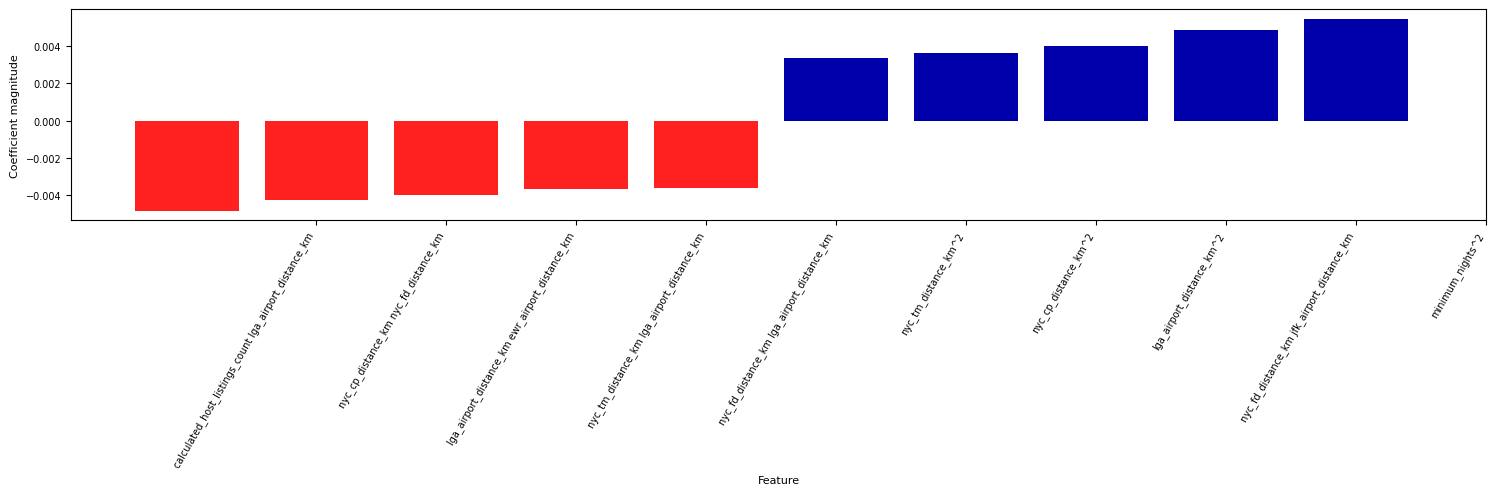

In [72]:
import mglearn

best_pipe = random_search_ridge.best_estimator_

ridge = best_pipe.named_steps["ridge"]
coef = np.ravel(ridge.coef_)

feature_names = best_pipe[:-1].get_feature_names_out()

coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coef})
coef_df["magnitude"] = coef_df["coefficient"].abs()

split = coef_df["feature"].str.split("__", n=1, expand=True)


if split.shape[1] == 2:
    coef_df["source"] = split[0]
    coef_df["feature_clean"] = split[1]
else:
    coef_df["source"] = None
    coef_df["feature_clean"] = split[0] 

top30 = (coef_df.sort_values("magnitude", ascending=False)
               .head(30)
               .reset_index(drop=True))

display(top30[["feature_clean", "source", "coefficient", "magnitude"]])


mglearn.tools.visualize_coefficients(
    coef,
    coef_df["feature_clean"].to_numpy(),
    n_top_features=5
)
plt.tight_layout()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 8. Different models <a name="8"></a>
rubric={accuracy,reasoning}

**Your tasks:**
1. Try out three other models aside from the linear model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat the performance of the linear model? 
    
</div>


_Points:_ 10

_Type your answer here, replacing this text._

In [57]:
from sklearn.ensemble import HistGradientBoostingRegressor

models = {
    "DecisionTree": DecisionTreeRegressor(
        random_state=RANDOM_STATE,
        max_depth=200,
        max_features=100
    ),
    "RandomForest": RandomForestRegressor(
        random_state=RANDOM_STATE,
        max_depth=20,
        n_estimators=50,      
        n_jobs=-1,             
        max_features=100,
    ),
    "GBR":  HistGradientBoostingRegressor(
        max_depth=8,
        learning_rate=0.05,
        max_iter=300,
        random_state=RANDOM_STATE
    )
}

for name, model in models.items():
    pipe = make_pipeline(
        general_preprocessor,
        model
    )
    mean, std = mean_std_cross_val_scores(
        pipe, X_train, y_train, scoring=score_types_reg
    )
    results_mean[name] = mean
    results_std[name] = std
    print(name)
    
mean_df = pd.DataFrame(results_mean).T
std_df = pd.DataFrame(results_std).T
results_df = mean_df.round(3).astype(str) + " ± " + std_df.round(3).astype(str)
results_df.T



DecisionTree
RandomForest
GBR


,Ridge,RandomForest,DecisionTree,GBR
fit_time,0.183 ± 0.028,12.006 ± 0.815,3.04 ± 0.09,8.828 ± 0.867
score_time,0.037 ± 0.007,0.077 ± 0.01,0.038 ± 0.011,0.109 ± 0.021
test_neg_root_mean_squared_error,-1.327 ± 0.01,-1.248 ± 0.018,-1.75 ± 0.012,-1.219 ± 0.018
train_neg_root_mean_squared_error,-1.314 ± 0.003,-0.601 ± 0.011,-0.0 ± 0.0,-1.015 ± 0.025
test_r2,0.253 ± 0.011,0.338 ± 0.008,-0.3 ± 0.024,0.369 ± 0.007
train_r2,0.268 ± 0.002,0.847 ± 0.005,1.0 ± 0.0,0.563 ± 0.021


In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-warning">

## 9. Feature selection (Challenging)
rubric={reasoning}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV`, forward/backward selection or L1 regularization for this. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises unless you think there are other benefits with using fewer features.
    
</div>


_Points:_ 0.5

_Type your answer here, replacing this text._

In [14]:
X_train_soft = X_train.copy()

soft_features = [
    "neighbourhood_group",
    "latitude",
    "longitude",
    "room_type",
    "price",
    "minimum_nights",
    "calculated_host_listings_count",
    "availability_365",
    "nyc_tm_distance_km",
    "nyc_cp_distance_km",
    "nyc_fd_distance_km",
    "jfk_airport_distance_km",
    "lga_airport_distance_km",
    "ewr_airport_distance_km",
    "avg_airport_distance_km",
    "total_min_cost",
    "len_name",
    "nb_adj_in_name",
    "nb_adv_in_name",
    "nb_nouns_in_name",
    "nb_propn_in_name",
    "rate_adj_in_name",
    "rate_adv_in_name",
    "rate_nouns_in_name",
    "rate_propn_in_name",
]

soft_cont_features = [f for f in soft_features if f not in categorical_features]
soft_preprocessor = make_column_transformer(
    (PolynomialFeatures(degree=2), cont_features),
    (StandardScaler(), cont_features),
    (
        OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
        categorical_features,
    ),
)
soft_preprocessor.set_output(transform="pandas")
X_train_soft_s = soft_preprocessor.fit_transform(X_train_soft)
X_train_soft_s["___RANDOM_1____"] = np.random.rand(len(X_train_soft))
X_train_soft_s["___RANDOM_2____"] = np.random.rand(len(X_train_soft))
soft_rf = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE, max_depth=6)
soft_rf.fit(X_train_soft_s, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
explainer = shap.TreeExplainer(soft_rf)
shap_values = explainer.shap_values(X_train_soft_s)

In [32]:
random_feats = ["___RANDOM_1____", "___RANDOM_2____"]
returned_features = soft_preprocessor.get_feature_names_out()
clean_features = [
    v.split("__", 1)[1] for v in returned_features if v not in random_feats
] + random_feats
ranked_features, selected_features = get_important_features_important_than(
    shap_values, clean_features, random_feats
)
print(f"{len(selected_features)} valuable features selected")
selected_features

90 valuable features selected


['latitude availability_365',
 'minimum_nights avg_airport_distance_km',
 'price availability_365',
 'longitude minimum_nights',
 'availability_365 ewr_airport_distance_km',
 'longitude availability_365',
 'latitude minimum_nights',
 'calculated_host_listings_count len_name',
 'availability_365 jfk_airport_distance_km',
 'latitude len_name',
 'calculated_host_listings_count ewr_airport_distance_km',
 'availability_365 nyc_fd_distance_km',
 'longitude len_name',
 'minimum_nights jfk_airport_distance_km',
 'room_type_Private room',
 'calculated_host_listings_count nyc_fd_distance_km',
 'minimum_nights calculated_host_listings_count',
 'avg_airport_distance_km len_name',
 'availability_365 len_name',
 'minimum_nights total_min_cost',
 'availability_365 avg_airport_distance_km',
 'availability_365 nb_propn_in_name',
 'nyc_tm_distance_km lga_airport_distance_km',
 'minimum_nights ewr_airport_distance_km',
 'minimum_nights availability_365',
 'latitude calculated_host_listings_count',
 'avai

In [26]:
for idx, v in enumerate(ranked_features):
    print(f"{idx + 1} - {v[0]} -> shap: {round(v[1],4)}")

1 - latitude availability_365 -> shap: 0.2634
2 - minimum_nights avg_airport_distance_km -> shap: 0.2056
3 - price availability_365 -> shap: 0.1541
4 - longitude minimum_nights -> shap: 0.1267
5 - availability_365 ewr_airport_distance_km -> shap: 0.0821
6 - longitude availability_365 -> shap: 0.0648
7 - latitude minimum_nights -> shap: 0.0424
8 - calculated_host_listings_count len_name -> shap: 0.0307
9 - availability_365 jfk_airport_distance_km -> shap: 0.0274
10 - latitude len_name -> shap: 0.025
11 - calculated_host_listings_count ewr_airport_distance_km -> shap: 0.0249
12 - availability_365 nyc_fd_distance_km -> shap: 0.0244
13 - longitude len_name -> shap: 0.0206
14 - minimum_nights jfk_airport_distance_km -> shap: 0.0168
15 - room_type_Private room -> shap: 0.0151
16 - calculated_host_listings_count nyc_fd_distance_km -> shap: 0.0111
17 - minimum_nights calculated_host_listings_count -> shap: 0.0096
18 - avg_airport_distance_km len_name -> shap: 0.0086
19 - availability_365 len_n

/var/folders/gc/x3q0m4h564d61kh41xdz_gy00000gn/T/ipykernel_4013/4231117112.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_soft_s, feature_names=clean_features, max_display=len(selected_features))


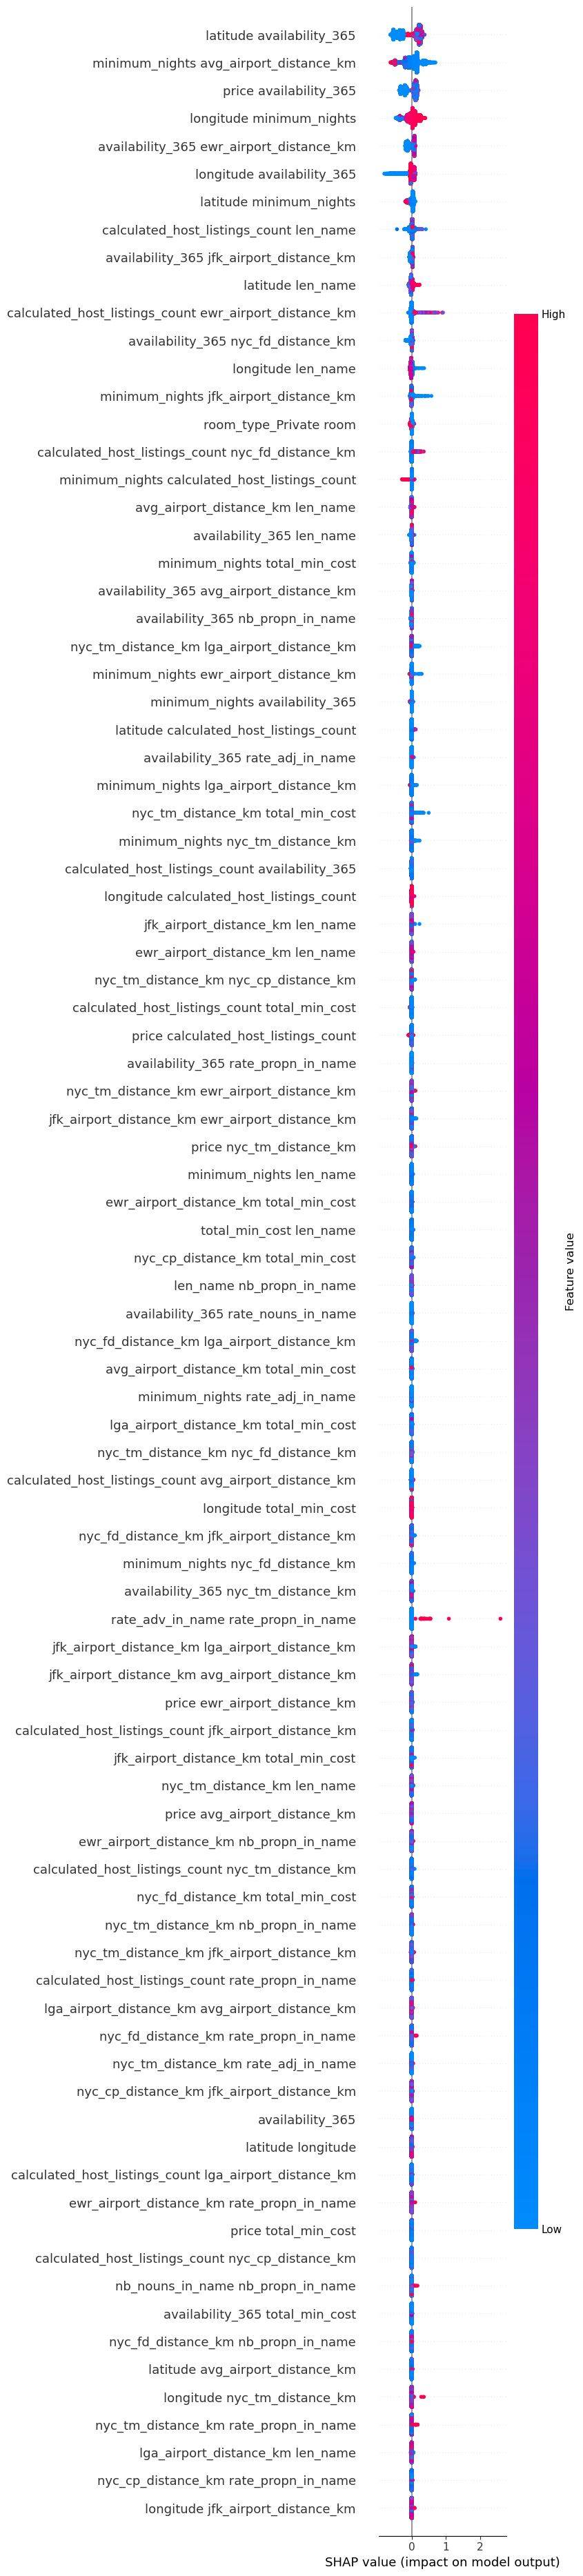

In [ ]:
plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 9,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
})

shap.summary_plot(
    shap_values,
    X_train_soft_s,
    feature_names=clean_features,
    max_display=len(selected_features),
)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 10. Hyperparameter optimization
rubric={accuracy,reasoning}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods.  Briefly summarize your results.
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 
    
</div>


_Points:_ 6

_Type your answer here, replacing this text._

In [68]:


param_grid = {
    "histgradientboostingregressor__max_depth": randint(40, 60),
    "histgradientboostingregressor__max_iter": randint(700, 1000),
    "histgradientboostingregressor__learning_rate": loguniform(0.005, 0.015)
}

random_search_hgbr = RandomizedSearchCV(
    make_pipeline(
        general_preprocessor,
        HistGradientBoostingRegressor(
            random_state=RANDOM_STATE
        )
    ),
    param_distributions=param_grid,
    n_iter=5,
    n_jobs= -1,
    return_train_score=True,
    verbose=3
)

random_search_hgbr.fit(X_train, y_train)

print(
    "Random Search best model score: \t %0.3f" % random_search_hgbr.best_score_
)



pd.DataFrame(random_search_hgbr.cv_results_)[
    [
        "mean_test_score",
        "mean_train_score",
        "param_histgradientboostingregressor__max_depth",
        "param_histgradientboostingregressor__max_iter",
        "param_histgradientboostingregressor__learning_rate",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()



Fitting 5 folds for each of 5 candidates, totalling 25 fits
Random Search best model score: 	 0.375


,mean_test_score,mean_train_score,param_histgradientboostingregressor__max_depth,param_histgradientboostingregressor__max_iter,param_histgradientboostingregressor__learning_rate,mean_fit_time
rank_test_score,,,,,,
1,0.374527,0.526722,40,998,0.005784,217.065892
2,0.374371,0.535432,57,916,0.009403,165.868851
3,0.373817,0.538871,51,766,0.010392,159.184929
4,0.373741,0.511925,53,719,0.006776,134.806347
5,0.373281,0.541082,53,720,0.011252,147.562699


In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 11. Interpretation and feature importances <a name="1"></a>
rubric={accuracy,reasoning}

**Your tasks:**

1. Use the methods we saw in class (e.g., `permutation_importance` or `shap`) (or any other methods of your choice) to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 
    
</div>


_Points:_ 8

_Type your answer here, replacing this text._

In [ ]:
# For random forest!

# explainer = shap.TreeExplainer(tr)
# shap_values = explainer.shap_values(X_train_soft_s)
# shap.summary_plot(
#     shap_values,
#     X_train_soft_s,
#     feature_names=clean_features,
#     max_display=len(selected_features),
# )

C:\Users\hpala\AppData\Local\Temp\ipykernel_25104\2574226130.py:35: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


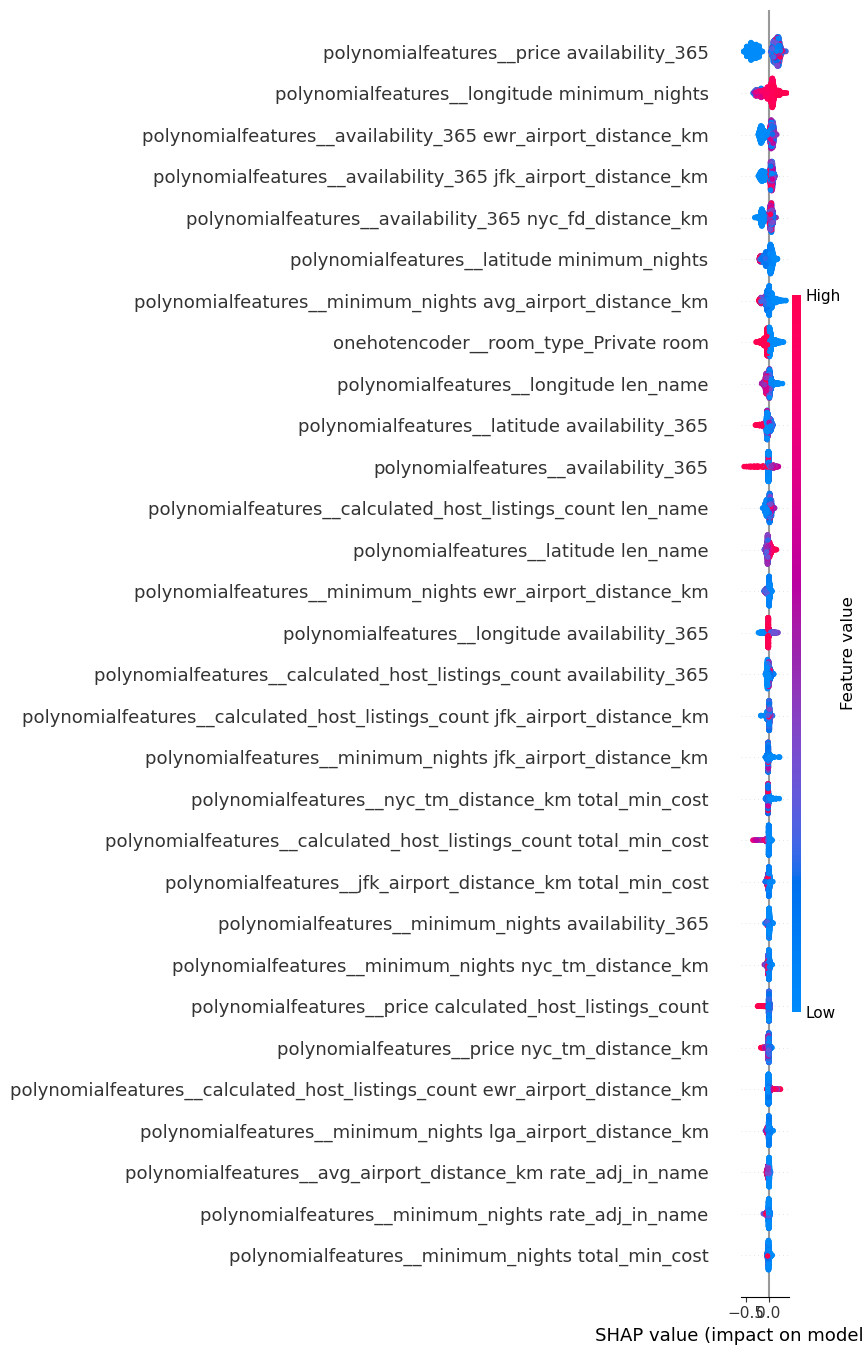

<Figure size 640x480 with 0 Axes>

C:\Users\hpala\AppData\Local\Temp\ipykernel_25104\2574226130.py:44: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


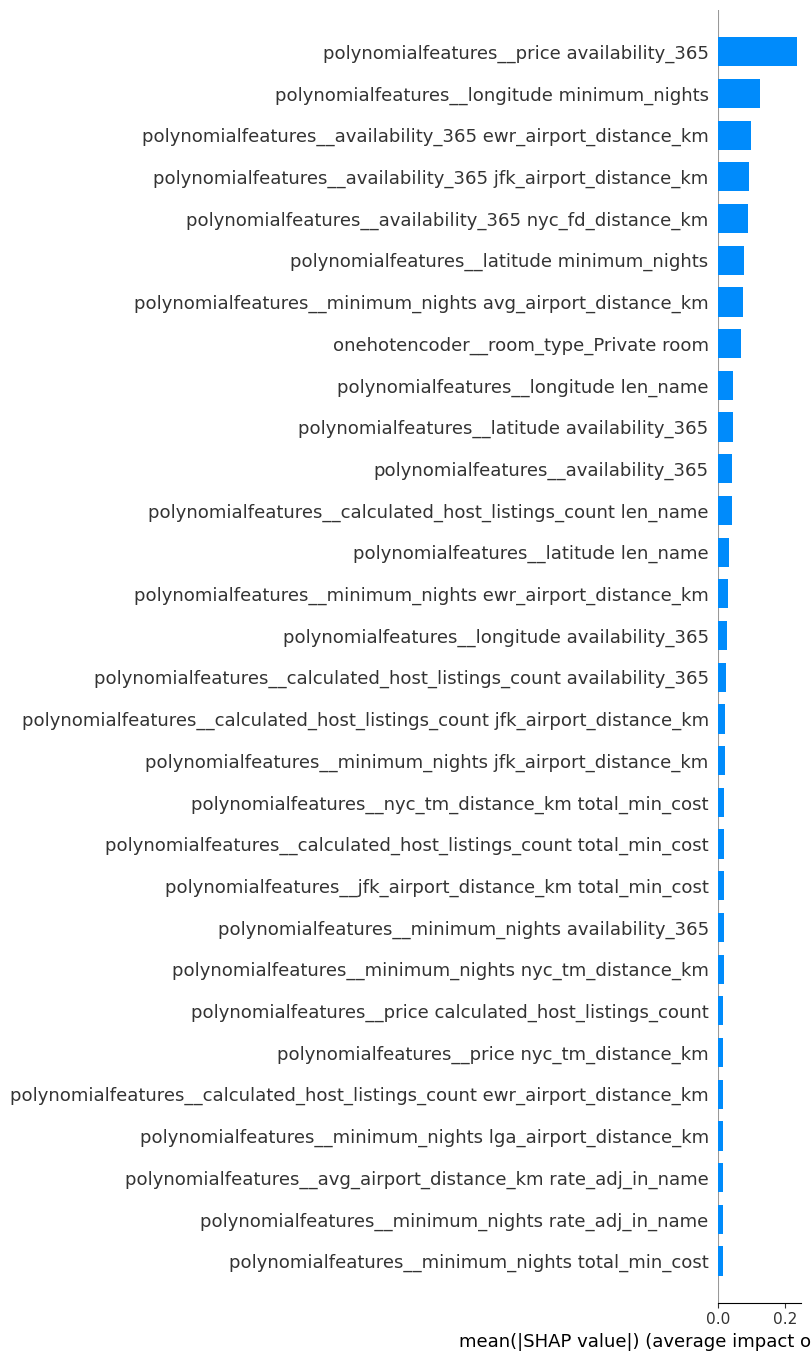

<Figure size 640x480 with 0 Axes>

In [75]:

from scipy import sparse


best_pipe = random_search_hgbr.best_estimator_
preprocess = best_pipe[:-1]
model = best_pipe.named_steps["histgradientboostingregressor"]


n = min(2000, len(X_train))
X_shap = X_train.sample(n=n, random_state=RANDOM_STATE)


X_shap_t = preprocess.transform(X_shap)
feature_names = preprocess.get_feature_names_out()


if sparse.issparse(X_shap_t):
    X_shap_t = X_shap_t.toarray()

X_shap_df = pd.DataFrame(X_shap_t, columns=feature_names)


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap_df)


plt.rcParams.update({
    "font.size": 3,
    "axes.titlesize": 3,
    "axes.labelsize": 3,
    "xtick.labelsize": 3,
    "ytick.labelsize": 3,
})

shap.summary_plot(
    shap_values,
    X_shap_df,
    max_display=30  
)
plt.tight_layout()
plt.show()


shap.summary_plot(
    shap_values,
    X_shap_df,
    plot_type="bar",
    max_display=30
)
plt.tight_layout()
plt.show()


In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 12. Results on the test set <a name="12"></a>
rubric={accuracy,reasoning}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain them with SHAP force plots.  
    
</div>


_Points:_ 6

_Type your answer here, replacing this text._

In [74]:
best_pipe.score(X_test, y_test)

0.3648321574290111

polynomialfeatures__total_min_cost^2                          160000.000000
polynomialfeatures__price total_min_cost                       32000.000000
polynomialfeatures__latitude total_min_cost                    16276.636000
polynomialfeatures__total_min_cost len_name                    10000.000000
polynomialfeatures__ewr_airport_distance_km total_min_cost      7395.550686
polynomialfeatures__price^2                                     6400.000000
polynomialfeatures__jfk_airport_distance_km total_min_cost      6356.802021
polynomialfeatures__avg_airport_distance_km total_min_cost      6154.918861
polynomialfeatures__longitude^2                                 5469.733994
polynomialfeatures__lga_airport_distance_km total_min_cost      4712.403876
polynomialfeatures__nyc_cp_distance_km total_min_cost           4056.797245
polynomialfeatures__latitude price                              3255.327200
polynomialfeatures__nyc_tm_distance_km total_min_cost           3133.534280
polynomialfe

Prediction: 0.3003480226733975


,feature,value,shap_value
72,polynomialfeatures__price availability_365,0.000000,-0.277241
135,polynomialfeatures__availability_365 ewr_airpo...,0.000000,-0.124474
49,polynomialfeatures__longitude minimum_nights,-369.788250,-0.124358
132,polynomialfeatures__availability_365 nyc_fd_di...,0.000000,-0.113238
133,polynomialfeatures__availability_365 jfk_airpo...,0.000000,-0.111357
27,polynomialfeatures__latitude minimum_nights,203.457950,-0.059163
120,polynomialfeatures__calculated_host_listings_c...,25.000000,-0.047551
115,polynomialfeatures__calculated_host_listings_c...,15.892005,-0.028901
99,polynomialfeatures__minimum_nights avg_airport...,76.936486,-0.025167
111,polynomialfeatures__calculated_host_listings_c...,0.000000,-0.023566


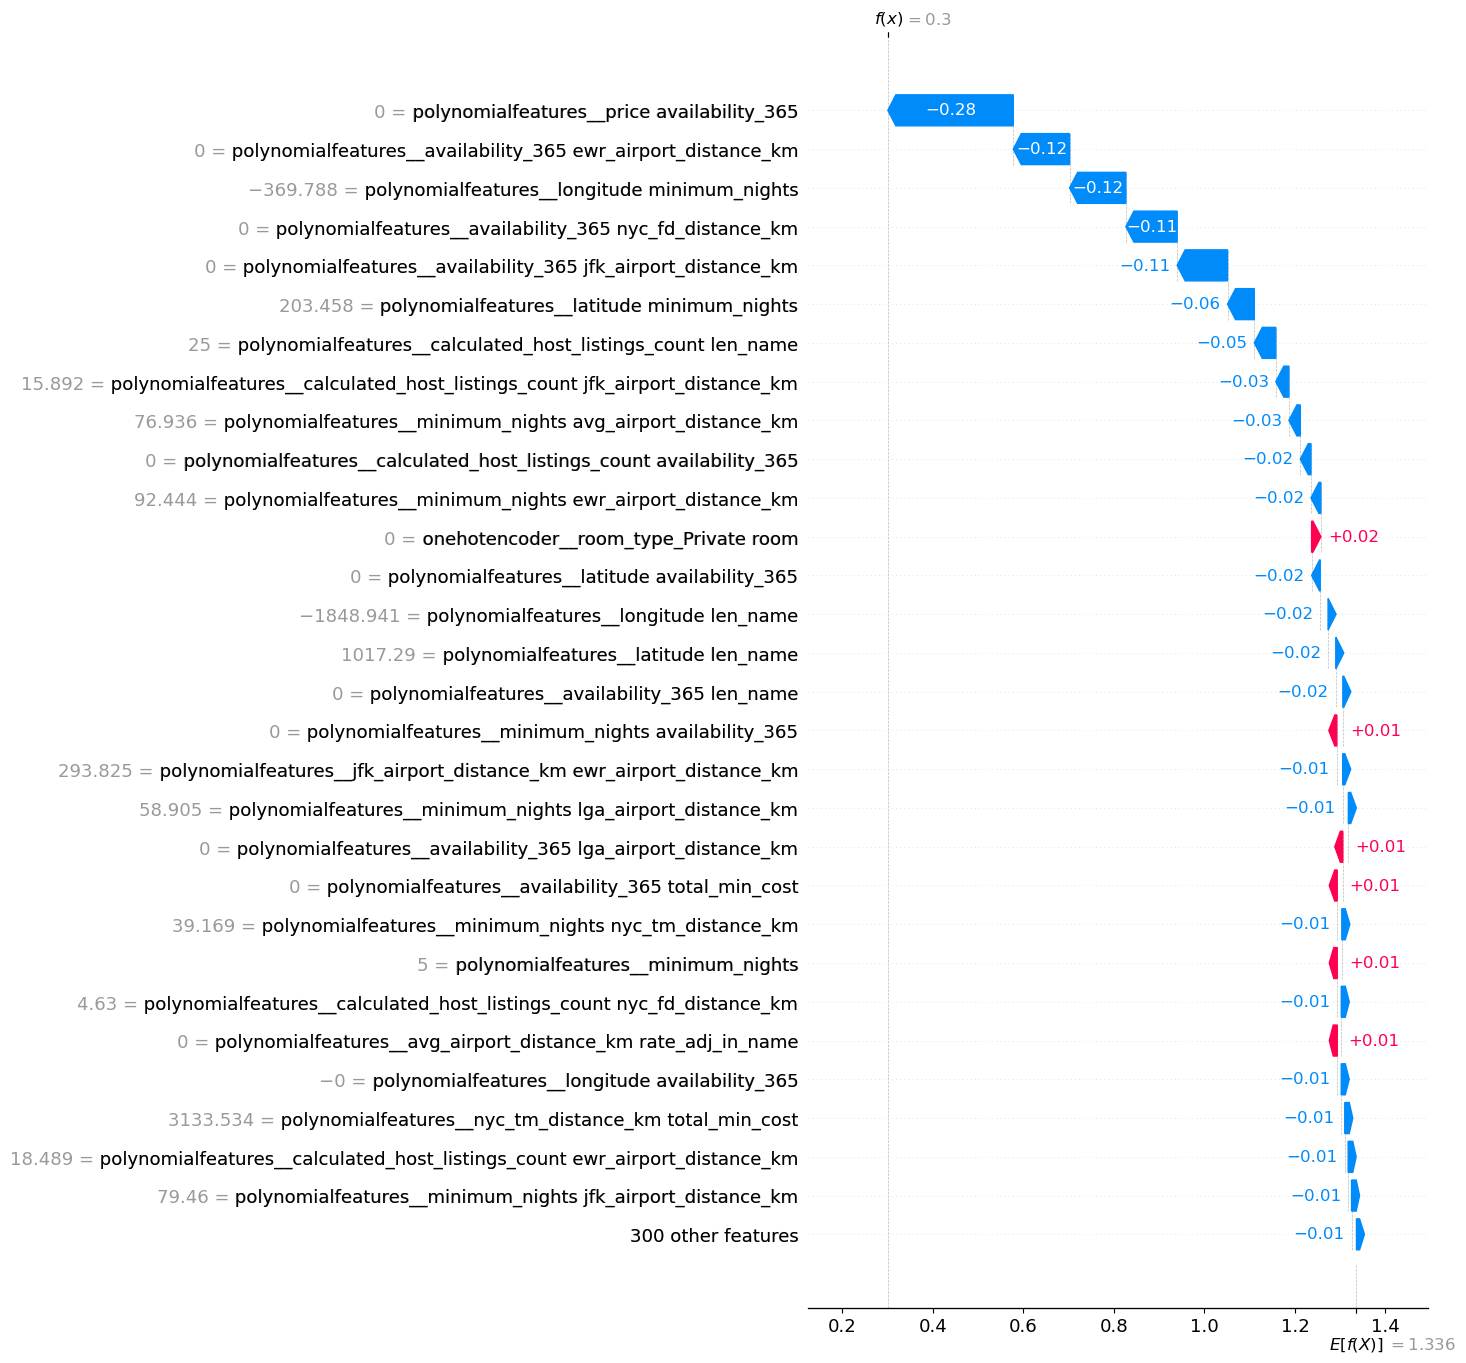

In [76]:

ex_index = 573

best_pipe = random_search_hgbr.best_estimator_
preprocess = best_pipe[:-1]
model = best_pipe.named_steps["histgradientboostingregressor"]


x_raw = X_test.iloc[[ex_index]]
x_enc = preprocess.transform(x_raw)

feature_names = preprocess.get_feature_names_out()

if sparse.issparse(x_enc):
    x_enc = x_enc.toarray()

x_enc_df = pd.DataFrame(x_enc, columns=feature_names)


display(x_enc_df.iloc[0].sort_values(ascending=False).head(30))


pred = best_pipe.predict(x_raw)[0]             
print("Prediction:", pred)



explainer = shap.TreeExplainer(model)


shap_values = explainer.shap_values(x_enc_df)


shap_df = (pd.DataFrame(
    {"feature": feature_names, "shap_value": shap_values[0], "value": x_enc_df.iloc[0].values}
).assign(abs_shap=lambda d: d.shap_value.abs())
 .sort_values("abs_shap", ascending=False))

display(shap_df[["feature", "value", "shap_value"]].head(30))


shap.initjs()


base_value = explainer.expected_value
exp = shap.Explanation(
    values=shap_values[0],
    base_values=base_value,
    data=x_enc_df.iloc[0].values,
    feature_names=feature_names,
)

shap.plots.waterfall(exp, max_display=30)

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

## 13. Summary of results <a name="13"></a>
rubric={reasoning}

Imagine that you want to present the summary of these results to your boss and co-workers. 

**Your tasks:**

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook.
    
</div>


_Points:_ 8

_Type your answer here, replacing this text._

In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-warning">

## 14. Creating a data analysis pipeline (Challenging)
rubric={reasoning}

**Your tasks:**

- Convert this notebook into scripts to create a reproducible data analysis pipeline with appropriate documentation. Submit your project folder in addition to this notebook on GitHub and briefly comment on your organization in the text box below.
    
</div>


_Points:_ 0.5

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-warning">

## 15. Your takeaway from the course (Challenging)
rubric={reasoning}

**Your tasks:**

What is your biggest takeaway from this course? 
    
</div>


_Points:_ 0.5

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<div class="alert alert-danger" style="color:black">
    
**Restart, run all and export a PDF before submitting**
    
Before submitting,
don't forget to run all cells in your notebook
to make sure there are no errors
and so that the TAs can see your plots on Gradescope.
You can do this by clicking the ▶▶ button
or going to `Kernel -> Restart Kernel and Run All Cells...` in the menu.
This is not only important for MDS,
but a good habit you should get into before ever committing a notebook to GitHub,
so that your collaborators can run it from top to bottom
without issues.
    
After running all the cells,
export a PDF of the notebook (preferably the WebPDF export)
and upload this PDF together with the ipynb file to Gradescope
(you can select two files when uploading to Gradescope)
</div>

---

## Help us improve the labs

The MDS program is continually looking to improve our courses, including lab questions and content. The following optional questions will not affect your grade in any way nor will they be used for anything other than program improvement:

1. Approximately how many hours did you spend working or thinking about this assignment (including lab time)?

#Ans:

2. Do you have any feedback on the lab you be willing to share? For example, any part or question that you particularly liked or disliked?

#Ans:

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)